In [1]:
# Standard Python Imports
import os
import json
import re
import string
import random
import time
import datetime
import matplotlib.pyplot as plt

# Extra non-standard utilities
from argparse import Namespace
from collections import Counter
from tqdm import tqdm
# import datasets

# Data management and Math imports
import numpy as np
import pandas as pd

# Torch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


# Hugging Face Imports
# from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertForMaskedLM, BertConfig, AdamW, logging
# from transformers import LineByLineTextDataset
from transformers import DataCollatorForLanguageModeling
from transformers import get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import pipeline
from transformers import EvalPrediction

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import math

/home/jz75/Documents/2023-2024/SH-Project/CS4099-LegalNLP/pytorchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.set_verbosity_error()

In [29]:
args = Namespace(
    model_save_path = "./models/mlm_model_manual",
    # model_save_path = "./models/casehold_mlm",
    data_filepath = './processed_data/sentences.csv',
    train_split = 0.7,
    num_samples = 5000,
    batch_size=8,
    learn_rate=2e-5,
    epochs=3,
    device='cpu'
)

In [4]:
# Load in data

raw_data_df = pd.read_csv(args.data_filepath)

raw_data_df = raw_data_df[:args.num_samples]

raw_data_df['split'] = 'train'
num_train_rows = int(len(raw_data_df) * (1 - args.train_split)//2) - 1
raw_data_df.loc[:num_train_rows, 'split'] = 'val'
raw_data_df.loc[num_train_rows:num_train_rows + num_train_rows, 'split'] = 'test'
raw_data_df.head()

,Unnamed: 0.1,Unnamed: 0,sentence,split
0,0,533.0,164 (indicating that a judgment of conviction ...,val
1,1,994.0,``(b) Any regulatory preemption of State law s...,val
2,2,1644.0,I threw this months receipt away during cleani...,val
3,3,1001.0,I live in Belgium and I was looking to buy som...,val
4,4,1561.0,"In sum, Smith has submitted a substantial amou...",val


In [5]:
print('Number of train samples : ' + str((raw_data_df['split'] == 'train').sum()))
print('Number of val samples : ' + str((raw_data_df['split'] == 'val').sum()))
print('Number of test samples : ' + str((raw_data_df['split'] == 'test').sum()))

Number of train samples : 3501
Number of val samples : 749
Number of test samples : 750


Text(0.5, 1.0, 'MLM Dataset Sentence Length Distribution')

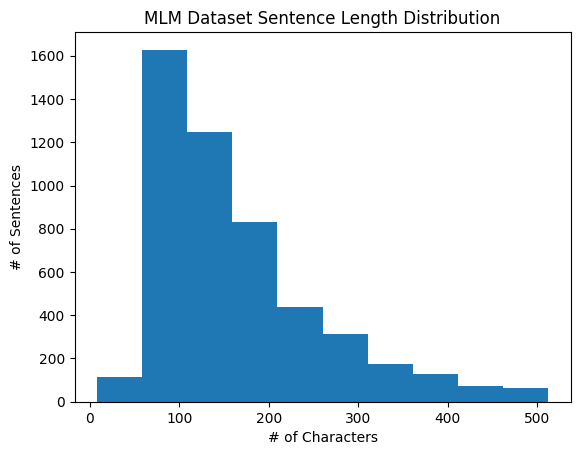

In [6]:
lengths = []
for index, row in raw_data_df.iterrows():
    lengths.append(len(row['sentence']))

plt.hist(lengths)
plt.xlabel('# of Characters')
plt.ylabel('# of Sentences')
plt.title('MLM Dataset Sentence Length Distribution')

In [7]:
tokenizer = BertTokenizer.from_pretrained('casehold/legalbert')

In [8]:
'''
    data collator will replace 15% of tokens with [MASK] token uniformly
'''
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [9]:
def encode_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

In [10]:
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings 

    def __getitem__(self, idx):
        return {key: val[idx] for key,val in self.encodings.item()}
    
    def __len__(self):
        return len(self.encodings.input_ids)

In [22]:
x = raw_data_df[raw_data_df['split'] == 'train']['sentence']
x.head()

1499    Do I have a chance of getting out of this felo...
1500    When the trial court renders a judgment for th...
1501    The Commission shall not accept a complaint \n...
1502    (c) Clarification of Part-Time or Intermittent...
1503    what information is contained in both systems ...
Name: sentence, dtype: object

### Prepare data splits 

In [11]:
encoded_data_train = [tokenizer(t) for t in raw_data_df[raw_data_df['split'] == 'train']['sentence'].tolist()]
dataloader_train = DataLoader(encoded_data_train, collate_fn=data_collator, batch_size=8)

encoded_data_val = [tokenizer(t) for t in raw_data_df[raw_data_df['split'] == 'val']['sentence'].tolist()]
dataloader_val = DataLoader(encoded_data_val, collate_fn=data_collator, batch_size=8)

encoded_data_test = [tokenizer(t) for t in raw_data_df[raw_data_df['split'] == 'test']['sentence'].tolist()]
dataloader_test = DataLoader(encoded_data_test, collate_fn=data_collator, batch_size=8)



In [12]:
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### Set up training

In [21]:
# model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model = AutoModelForMaskedLM.from_pretrained("./models/sentence_pair_classification")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=args.learn_rate)

num_train_steps = len(dataloader_train) * args.epochs
num_warmup_steps = num_train_steps * 0.1

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)


/home/jz75/Documents/2023-2024/SH-Project/CS4099-LegalNLP/pytorchenv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
epoch_bar = tqdm(desc='Training Routine', total=args.epochs, position=1)
train_bar = tqdm(desc='Split=Train', total=len(dataloader_train), position=1)
validation_bar = tqdm(desc='Split=Val', total=len(dataloader_val), position=1)

train_bar.n = 0
validation_bar.n = 0
epoch_bar.n = 0

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)
for epoch in range(args.epochs):

    total_train_loss = 0
    total_train_accuracy = 0

    for step,batch in enumerate(dataloader_train):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        input_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_train_accuracy += calculate_accuracy(logits, labels)

        optimizer.step()
        scheduler.step()

        train_bar.update(1)

        # print(f"Epoch : {epoch}")
        # print(f"Loss : {loss.item()}")

    avg_train_loss = total_train_loss/len(dataloader_train)
    print(f'Epoch {epoch}: Average Training Loss: {avg_train_loss}')
    
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in dataloader_val:
        input_ids = batch['input_ids'].to(device)
        input_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask)

        
        logits = outputs.logits.view(-1, outputs.logits.size(-1))
        labels = labels.view(-1)
        loss = loss_fn(logits, labels)

        # logits = outputs.logits.detach().cpu().numpy()
        # label_ids = labels.to('cpu').numpy()
        # total_eval_loss += loss_fn(outputs.logits.squeeze(-1), labels).item() # perhaps just outputs.loss (need to include labels as parameter in model() above)
        # loss = loss_fn(outputs)


        total_eval_loss += loss

        predicted_token_indices = torch.argmax(logits, dim=-1)
        mask = labels != -100
        relevant_labels = labels[mask]
        relevant_predictions = predicted_token_indices[mask]

        accuracy = (relevant_predictions == relevant_labels).float().mean().item()

        total_eval_accuracy += accuracy

        validation_bar.update(1)

    avg_val_accuracy = total_eval_accuracy/len(dataloader_val)
    print(f'Epoch {epoch}: Validation Accuracy: {avg_val_accuracy}')


    train_bar.n = 0
    validation_bar.n = 0
    epoch_bar.update()

        





Epoch 0: Average Training Loss: 6.381820155605333


Epoch 0: Validation Accuracy: 0.31986323581572546


Epoch 1: Average Training Loss: 4.153122080515509


Epoch 1: Validation Accuracy: 0.3822492170841136
Epoch 2: Average Training Loss: 3.7903399418478143


Epoch 2: Validation Accuracy: 0.403785525801334


In [23]:
model.save_pretrained(args.model_save_path)

## Testing + Evaluation

In [24]:
text1 = 'Yet they lie wholly outside the scope of Parliamentary [MASK].' #law

text2 = 'The opening words of section 3(1) of the 1934 Act provided that the 1923 Act was to apply for the purpose of enabling a person holding a [MASK] under this Act to acquire such ancillary rights as may be required for the exercise of the rights granted by the licence, and shall have effect accordingly.' # license

mlm_model = AutoModelForMaskedLM.from_pretrained(args.model_save_path)

pipeline_model = pipeline('fill-mask', model=mlm_model, tokenizer=tokenizer, top_k=10)

result = pipeline_model(text2)

for pred in result:
    print(f">>> {pred['sequence']}")

>>> the opening words of section 3 ( 1 ) of the 1934 act provided that the 1923 act was to apply for the purpose of enabling a person holding a term under this act to acquire such ancillary rights as may be required for the exercise of the rights granted by the licence, and shall have effect accordingly.
>>> the opening words of section 3 ( 1 ) of the 1934 act provided that the 1923 act was to apply for the purpose of enabling a person holding a court under this act to acquire such ancillary rights as may be required for the exercise of the rights granted by the licence, and shall have effect accordingly.
>>> the opening words of section 3 ( 1 ) of the 1934 act provided that the 1923 act was to apply for the purpose of enabling a person holding a act under this act to acquire such ancillary rights as may be required for the exercise of the rights granted by the licence, and shall have effect accordingly.
>>> the opening words of section 3 ( 1 ) of the 1934 act provided that the 1923 ac

In [25]:
def evaluate_mlm_perplexity(model_path, title):
    '''
        Routine for evaluating model on test split 
    '''
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-100)

    # Load model 
    test_model = AutoModelForMaskedLM.from_pretrained(model_path)

    # tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    
    test_model.to(device)

    test_model.eval()

    losses = []

    with torch.no_grad():
        for batch in dataloader_test:
            input_ids = batch['input_ids'].to(device)
            input_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = test_model(input_ids, token_type_ids=None, attention_mask=input_mask)

            logits = outputs.logits.view(-1, outputs.logits.size(-1))
            labels = labels.view(-1)
            loss = loss_fn(logits, labels) 

            losses.append(loss.unsqueeze(0))

        losses = torch.cat(losses)

        try:
            perplexity = math.exp(torch.mean(losses))
        except OverflowError:
            perplexity = float('inf')
        print(title, f"Perplexity: {perplexity}")
        

            


In [26]:
def evaluate_mlm_accuracy(model_path, title, k=5):
    '''
        Routine for evaluating model on test split 
    '''

    # Load model 
    test_model = AutoModelForMaskedLM.from_pretrained(model_path)

    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    
    test_model.to(device)

    test_model.eval()

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader_test:
            input_ids = batch['input_ids'].to(device)
            input_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = test_model(input_ids, token_type_ids=None, attention_mask=input_mask)

            logits = outputs.logits

            # Get top-K predictions
            _, top_k_indices = torch.topk(logits, k, dim=-1)

            for i in range(input_ids.size(0)):  # Loop over batch
                for j in range(input_ids.size(1)):  # Loop over sequence length
                    if labels[i, j].item() != -100:  # Check if position is masked
                        if labels[i, j].item() in top_k_indices[i, j].tolist():
                            correct_predictions += 1
                        total_samples += 1


    top_k_accuracy = correct_predictions / total_samples
    print(title, 'Top', k, 'Accuracy :', top_k_accuracy)


In [30]:
print('Evaluation Metrics')
print('====================================')
evaluate_mlm_accuracy('bert-base-uncased',  "Bert Base Model", 5)
evaluate_mlm_accuracy(args.model_save_path,  "Fine Tuned Model MLM", 5)
evaluate_mlm_accuracy("models/casehold_mlm",  "Fine Tuned Model MLM+SPC", 5)
print()
evaluate_mlm_accuracy('bert-base-uncased',  "Bert Base Model", 10)
evaluate_mlm_accuracy(args.model_save_path,  "Fine Tuned Model MLM", 10)
evaluate_mlm_accuracy("models/casehold_mlm",  "Fine Tuned Model MLM+SPC", 10)
# print()
evaluate_mlm_perplexity("bert-base-uncased", "Bert Base Model ")
evaluate_mlm_perplexity(args.model_save_path, "Fine Tuned Model MLM")
evaluate_mlm_perplexity("models/casehold_mlm",  "Fine Tuned Model MLM+SPC")
print()


Evaluation Metrics
Bert Base Model Top 5 Accuracy : 0.720440881763527
Fine Tuned Model MLM Top 5 Accuracy : 0.7834605597964377
Fine Tuned Model MLM+SPC Top 5 Accuracy : 0.5538461538461539

Bert Base Model Top 10 Accuracy : 0.7744903033316758
Fine Tuned Model MLM Top 10 Accuracy : 0.8348333738749696
Fine Tuned Model MLM+SPC Top 10 Accuracy : 0.6210399032648126
Bert Base Model  Perplexity: 17.73017063395483
Fine Tuned Model MLM Perplexity: 7.211398842544351
Fine Tuned Model MLM+SPC Perplexity: 44.84593317491587

